# March Madness Rating Computation

In [118]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_format.rating_systems.stephenson import *
from data_format.rating_systems.glicko2 import *
from data_format.rating_systems.elo_v2 import *
import copy
import lightgbm as lgb
import xgboost as xgb # ask bojan tunguz why you have to use it
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, brier_score_loss, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline # interpolate win margin model to probabilities



In [119]:
DATA_PATH = 'data/'

gender = 'w'

if gender == 'm':
    adj_path = "mens/M"
    day_cutoff = 136
else:
    adj_path = "womens/W"
    day_cutoff = 137

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "NCAATourneyDetailedResults.csv"),
], ignore_index=True)

second_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "SecondaryTourneyCompactResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "NCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + adj_path + "RegularSeasonDetailedResults.csv"),
], ignore_index=True)

potential_matchups = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneySeedRoundSlots.csv"),
], ignore_index=True)

In [120]:
def prepare_data(df):
    df['WOER'] = df['WScore'] / ((df['WFGA'] + .44 * df['WFTA'] - df['WOR'] + df['WTO'])/2)
    df['LOER'] = df['LScore'] / ((df['LFGA'] + .44 * df['LFTA'] - df['LOR'] + df['LTO'])/2)

    #Performs worse V
    # df['WOER'] = df['WScore'] / (df['WFGA'] - df['WOR'] + df['WTO'] + (0.4 * df['WFTA']))
    # df['LOER'] = df['LScore'] / (df['LFGA'] - df['LOR'] + df['LTO'] + (0.4 * df['LFTA']))

    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LOER',
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WOER']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    output['win'] = np.where(output['T1_Score']>output['T2_Score'], 1, 0)

    output['T1_TeamID'] = output['T1_TeamID'].astype(int)
    output['T2_TeamID'] = output['T2_TeamID'].astype(int)
    
    return output

In [121]:
tourney_data = prepare_data(tourney_results)
regular_data = prepare_data(regular_results)

second_tourney_results['score'] = second_tourney_results["WScore"] - second_tourney_results["LScore"]
second_tourney_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(second_tourney_results.columns)]
second_tourney_results['win'] = 1

In [122]:
# not interested in pre-selection matches - first four started 2011 mens 2022 women
# 136 FOR MENS 137 FOR WOMEN
tourney_data = tourney_data.loc[tourney_data['DayNum'] >= day_cutoff].reset_index(drop=True)

# #Add round
def assign_intervals(day_nums):
    day_to_interval = {}
    days = sorted(set(day_nums)) #unique + sorted

    interval_mapping = {
        (0, 1): 1, # First round
        (2, 3): 2, # Second round
        (4, 5): 3, # Sweet sixteen
        (6, 7): 4, # Elite eight
        (8, 8): 5, # Final four
        (9, 9): 6, # Finals
    }

    for i, day in enumerate(days):
        for (start, end), interval in interval_mapping.items():
            if start <= i <= end:
                day_to_interval[day] = interval
                break

    return day_nums.map(day_to_interval)  # Map backto index

# Apply function to each Season group
tourney_data['round'] = tourney_data.groupby("Season")['DayNum'].transform(assign_intervals)
# tourney_data = tourney_data.drop(columns=['DayNum'])

In [123]:
# boxscore_cols = ['T1_Score', 'T2_Score', 
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T1_OER',
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'T2_OER',
#         'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 'T1_OER',
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'T2_OER',
        'PointDiff']

# boxscore_cols = [
#         'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
#         'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
#         'PointDiff']

In [124]:

season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean")
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean").reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [125]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [126]:
tourney_data = tourney_data[['Season', 'round', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score', 'win']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [127]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [128]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [129]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(8628, 5)

In [130]:
def update_team_rating_s(df_team, row, rating_type='rating'):
    team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], rating_type].values[0]
    team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], rating_type].values[0]

    #Replacing updateVal since this is not by date but by week 10^2 = 100 (cval)
    team_one.sigma = team_one.sigma + 100
    team_two.sigma = team_two.sigma + 100

    # So we don't evaluate on outcome
    home_clone = copy.deepcopy(team_one)

    point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score']) if rating_type != 'rating' else row['win']

    if row is not None and 'location' in row:
        match row['location']:
            case 'H':
                team_one.newVarRating(team_two, point_ratio, 1)  # pone is 1 for home team, -1 away, 0 unknown
                team_two.newVarRating(home_clone, (1 - point_ratio), -1) 
            case 'A':
                team_one.newVarRating(team_two, point_ratio, -1)
                team_two.newVarRating(home_clone, (1 - point_ratio), 1) 
            case _:
                team_one.newVarRating(team_two, point_ratio, 0)
                team_two.newVarRating(home_clone, (1 - point_ratio), 0) 
    else:
        team_one.newVarRating(team_two, point_ratio, 0)
        team_two.newVarRating(home_clone, (1 - point_ratio), 0)


    df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'] = team_one
    df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'] = team_two

    return df_team

def update_quality_s(df_team):
    df_team = df_team.assign(
        quality=df_team['rating'].apply(lambda x: x.getRating()),
        quality_points=df_team['point_rating'].apply(lambda x: x.getRating())
    )
    df_team = df_team.sort_values(by="quality", ascending=False)
    return df_team

def create_team_df_s(df_team, season):
    df_team = df_team[['TeamID', 'quality', 'quality_points']].reset_index(drop=True)
    df_team['Season'] = season
    df_team['TeamID'] = df_team['TeamID'].astype(int)
    return df_team

def team_quality_s(season_start, season_end, exclude):
    all_team_data = []
    new_year_ratio = 1

    previous_season_teams = {}
    previous_season_teams_points = {}

    for season in range(season_start, season_end + 1):
        if season in exclude:
            continue

        print(season)

        year_regular_results = regular_data[(regular_data['Season'] == season)]
        year_tourney_results = pd.concat([tourney_data[tourney_data['Season'] == season], second_tourney_results[second_tourney_results['Season'] == season]])
        year_tourney_results = year_tourney_results.sort_values(by='DayNum')
        combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
        all_teams = combined_teams.drop_duplicates().tolist()

        team_data = {
            'TeamID': all_teams,
            'rating': [Stephenson() for _ in all_teams],
            'point_rating': [Stephenson() for _ in all_teams],
        }

        df_team = pd.DataFrame(team_data)
        df_team['TeamID'] = df_team['TeamID'].astype(int)

        if previous_season_teams:
            for index, row in df_team.iterrows():
                if row['TeamID'] in previous_season_teams:
                    prev_rating = previous_season_teams[row['TeamID']]
                    update_rating = prev_rating * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'rating'] = Stephenson(mu=update_rating, sigma=80)

                    prev_rating_2 = previous_season_teams_points[row['TeamID']]
                    update_rating_2 = prev_rating_2 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'point_rating'] = Stephenson(mu=update_rating_2, sigma=80)

        for index, row in year_regular_results.iterrows():
            df_team = update_team_rating_s(df_team, row, rating_type='rating')
            df_team = update_team_rating_s(df_team, row, rating_type='point_rating')

        df_team = update_quality_s(df_team)
        new_team_df = create_team_df_s(df_team, season)
        all_team_data.append(new_team_df)

        for index, row in year_tourney_results.iterrows():
            df_team = update_team_rating_s(df_team, row, rating_type='rating')
            df_team = update_team_rating_s(df_team, row, rating_type='point_rating')

        df_team = update_quality_s(df_team)
        march_team_df = create_team_df_s(df_team, season)

        previous_season_teams = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality'])}
        previous_season_teams_points = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_points'])}

    return pd.concat(all_team_data, ignore_index=True)


In [131]:
def update_team_rating(df_team, row, rating_type='rating'):
    # if rating_type == 'offensive_rating':
    #     rating_type_b = 'defensive_rating'
    # elif rating_type == 'defensive_rating':
    #     rating_type_b ='offensive_rating'
    # else:
    #     rating_type_b = rating_type

    team_one = df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], rating_type].values[0]
    team_two = df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type].values[0]
    # team_two = df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type_b].values[0]
    
    home_point = copy.deepcopy(team_one)

    if rating_type == 'rating':
        validation = row['win']
    elif rating_type == 'point_rating':
        validation = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
    elif rating_type == 'offensive_rating':
        validation = row['T1_OER']
    else:
        validation = (1-row['T2_OER'])
    
    team_one.update_player(team_two.getRating(), team_two.getRd(), validation)
    team_two.update_player(home_point.getRating(), home_point.getRd(), (1 - validation))
    
    peak_rating_col = 'peak_' + rating_type

    df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], rating_type] = team_one
    # if team_one.getRating() > df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], peak_rating_col].values[0]:
    #     df_team.loc[df_team['TeamID'] == row[f'T1_TeamID'], peak_rating_col] = team_one.getRating()

    df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type] = team_two
    # df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], rating_type_b] = team_two
    # if team_two.getRating() > df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], peak_rating_col].values[0]:
    #     df_team.loc[df_team['TeamID'] == row[f'T2_TeamID'], peak_rating_col] = team_two.getRating()

    return df_team

def update_quality(df_team):
    df_team = df_team.assign(
        quality=df_team['rating'].apply(lambda x: x.getRating()),
        # quality_peak=df_team['peak_rating'],
        quality_vol=df_team['rating'].apply(lambda x: x.getVol()),
        quality_points=df_team['point_rating'].apply(lambda x: x.getRating()),
        # quality_points_peak=df_team['peak_point_rating'],
        quality_points_vol=df_team['point_rating'].apply(lambda x: x.getVol()),
        # quality_offense=df_team['offensive_rating'].apply(lambda x: x.getRating()),
        # quality_defense=df_team['defensive_rating'].apply(lambda x: x.getRating()),

    )
    df_team = df_team.sort_values(by="quality", ascending=False)
    return df_team

def create_team_df(df_team, season):
    # df_team = df_team[['TeamID', 'quality', 'quality_peak', 'quality_vol', 'quality_points', 'quality_points_peak', 'quality_points_vol']].reset_index(drop=True)
    # df_team = df_team[['TeamID', 'quality', 'quality_vol', 'quality_points', 'quality_points_vol', 'quality_offense', 'quality_defense']].reset_index(drop=True)
    df_team = df_team[['TeamID', 'quality', 'quality_vol', 'quality_points', 'quality_points_vol']].reset_index(drop=True)
    df_team['Season'] = season
    df_team['TeamID'] = df_team['TeamID'].astype(int)
    return df_team

def team_quality_v2(season_start, season_end, exclude):
    all_team_data = []
    new_year_ratio = 1

    previous_season_teams = {}
    previous_season_teams_points = {}
    # previous_season_teams_offense = {}
    # previous_season_teams_defense = {}

    for season in range(season_start, season_end + 1):
        if season in exclude:
            continue

        print(season)

        year_regular_results = regular_data[(regular_data['Season'] == season)]
        year_tourney_results = pd.concat([tourney_data[tourney_data['Season'] == season], second_tourney_results[second_tourney_results['Season'] == season]])
        year_tourney_results = year_tourney_results.sort_values(by='DayNum')
        combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
        all_teams = combined_teams.drop_duplicates().tolist()

        team_data = {
            'TeamID': all_teams,
            'rating': [Rating() for _ in all_teams],
            # 'peak_rating': float(START_RATING),
            'point_rating': [Rating() for _ in all_teams],
            # 'peak_point_rating': float(START_RATING),
            # 'offensive_rating': [Rating() for _ in all_teams],
            # 'defensive_rating': [Rating() for _ in all_teams],

        }

        df_team = pd.DataFrame(team_data)
        df_team['TeamID'] = df_team['TeamID'].astype(int)

        if previous_season_teams:
            for index, row in df_team.iterrows():
                if row['TeamID'] in previous_season_teams:
                    prev_rating = previous_season_teams[row['TeamID']]
                    update_rating = prev_rating * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'rating'] = Rating(rating=update_rating, rd=80)

                    prev_rating_2 = previous_season_teams_points[row['TeamID']]
                    update_rating_2 = prev_rating_2 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    df_team.loc[index, 'point_rating'] = Rating(rating=update_rating_2, rd=80)

                    # prev_rating_3 = previous_season_teams_offense[row['TeamID']]
                    # update_rating_3 = prev_rating_3 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    # df_team.loc[index, 'offensive_rating'] = Rating(rating=update_rating_3, rd=80)

                    # prev_rating_4 = previous_season_teams_defense[row['TeamID']]
                    # update_rating_4 = prev_rating_4 * new_year_ratio + START_RATING * (1 - new_year_ratio)
                    # df_team.loc[index, 'defensive_rating'] = Rating(rating=update_rating_4, rd=80)

        for index, row in year_regular_results.iterrows():
            df_team = update_team_rating(df_team, row, rating_type='rating')
            df_team = update_team_rating(df_team, row, rating_type='point_rating')
            # df_team = update_team_rating(df_team, row, rating_type='offensive_rating')
            # df_team = update_team_rating(df_team, row, rating_type='defensive_rating')

        df_team = update_quality(df_team)
        new_team_df = create_team_df(df_team, season)
        all_team_data.append(new_team_df)

        for index, row in year_tourney_results.iterrows():
            df_team = update_team_rating(df_team, row, rating_type='rating')
            df_team = update_team_rating(df_team, row, rating_type='point_rating')
            # df_team = update_team_rating(df_team, row, rating_type='offensive_rating')
            # df_team = update_team_rating(df_team, row, rating_type='defensive_rating')

        df_team = update_quality(df_team)
        march_team_df = create_team_df(df_team, season)

        previous_season_teams = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality'])}
        previous_season_teams_points = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_points'])}
        # previous_season_teams_offense = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_offense'])}
        # previous_season_teams_defense = {team_id: rating for team_id, rating in zip(march_team_df['TeamID'], march_team_df['quality_defense'])}

    return pd.concat(all_team_data, ignore_index=True)


In [132]:
glm_quality = team_quality_v2(2004, 2024, {2020})

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2021
2022
2023
2024


In [133]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
# glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_peak','T1_quality_vol','T1_quality_points','T1_quality_points_peak','T1_quality_points_vol','Season']
# glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_peak','T2_quality_vol','T2_quality_points','T2_quality_points_peak','T2_quality_points_vol','Season']

# glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_vol','T1_quality_points','T1_quality_points_vol','T1_quality_offense','T1_quality_defense','Season']
# glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_vol','T2_quality_points','T2_quality_points_vol','T2_quality_offense','T2_quality_defense','Season']

glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_vol','T1_quality_points','T1_quality_points_vol','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_vol','T2_quality_points','T2_quality_points_vol','Season']

# glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_points','Season']
# glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_points','Season']

glm_quality_T1['T1_TeamID'] = glm_quality_T1['T1_TeamID'].astype(str)
glm_quality_T2['T2_TeamID'] = glm_quality_T2['T2_TeamID'].astype(str)

tourney_data['T1_TeamID'] = tourney_data['T1_TeamID'].astype(str)
tourney_data['T2_TeamID'] = tourney_data['T2_TeamID'].astype(str)


In [134]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [135]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [136]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

seeds_T1['T1_TeamID'] = seeds_T1['T1_TeamID'].astype(str)
seeds_T2['T2_TeamID'] = seeds_T2['T2_TeamID'].astype(str)

In [137]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [138]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data["qual_diff"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]
tourney_data["qual_point_diff"] = tourney_data["T1_quality_points"] - tourney_data["T2_quality_points"]
tourney_data["avg_qual_point"] = (tourney_data["T1_quality_points"] + tourney_data["T2_quality_points"])/2
tourney_data["avg_qual"] = (tourney_data["T1_quality"] + tourney_data["T2_quality"])/2

tourney_data = tourney_data.dropna()

# March Madness teams - team strength overview

In [139]:
def trainModel(features, df_train, df_validate):
    y_train = df_train["Result"]
    y_validate = df_validate["Result"]

    X_train = df_train[features]
    X_validate = df_validate[features]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_validate, label=y_validate, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 7, #31
        'learning_rate': 0.02, #0.05 #change to ~0.02 for final run
        'feature_fraction': 0.7, #0.9, # 1 by default - helps overfitting
        # 'bagging_freq' : 10,
        'verbosity': -1,
        # 'boost_from_average': True,
        # 'feature_pre_filter': False,
        'subsample': 0.35,
        'min_child_samples': 40,
        'lambda_l1': 10,
    }

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=3000, #50 # More iterations for better convergence
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=25)], #25 #50
    )

    # Return the trained model
    return gbm

In [140]:
def evaluateModel(model, df_test, features):
    X_test = df_test[features]
    y_test = df_test["Result"]

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Convert numerical predictions to binary (1 if positive, 0 if negative)
    y_test_binary = (y_test > 0).astype(int)
    y_pred_binary = (y_pred > 0).astype(int)

    # Compute regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    brier = brier_score_loss(y_test_binary, np.clip(y_pred, 0, 1))  # Clipping for Brier score

    # Compute classification metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    auc = roc_auc_score(y_test_binary, y_pred_binary)

    return {
        'mae': mae,
        'brier_score': brier,
        'accuracy': accuracy,
        'auc': auc
    }

In [141]:
# Data cleaning and filtering
# df = tourney_data.dropna()

# y = df['T1_Score'] - df['T2_Score']

# df = df.drop(columns=['Season', 'T1_TeamID', 'T1_Score','T2_TeamID', 'T2_Score','win'])

# X = df.to_numpy()  # Ensures full conversion without dropping metadata

# Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split data
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.3, random_state=42
# )

# X_validate, X_test, y_validate, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, random_state=42
# )








# # Convert to DataFrames for model compatibility
# df_train = pd.DataFrame(X_train, columns=df.columns)
# df_train['Result'] = y_train.reset_index(drop=True)

# df_validate = pd.DataFrame(X_validate, columns=df.columns)
# df_validate['Result'] = y_validate.reset_index(drop=True)

# df_test = pd.DataFrame(X_test, columns=df.columns)
# df_test['Result'] = y_test.reset_index(drop=True)


# # Train model
# selected_features = df_train.columns.drop('Result').tolist()
# model = trainModel(selected_features, df_train, df_validate)

# # Evaluate model
# evaluation_metrics = evaluateModel(model, df_validate, selected_features)

# print(f"Accuracy: {evaluation_metrics['accuracy']:.4f}")
# print(f"AUC: {evaluation_metrics['auc']:.4f}")
# print(f"Mae: {evaluation_metrics['mae']:.4f}")
# print(f"brier: {evaluation_metrics['brier_score']:.4f}")

# # Feature importance
# importances = model.feature_importance()
# feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(15, 10))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

# # Save model
# model.save_model('lightgbm_model.txt')

# # Predictions
# y_pred = model.predict(X_test)

# # brier = brier_score_loss(y_test, y_pred)  # Use probabilities
# # print(f"Brier: {brier}")


# # Convert all inputs to DataFrames/Series and reset index to ensure alignment
# X_test = pd.DataFrame(X_test).reset_index(drop=True) if isinstance(X_test, np.ndarray) else X_test.reset_index(drop=True)
# X_test.columns = selected_features


# y_pred = pd.Series(y_pred, name="y_pred").reset_index(drop=True) if isinstance(y_pred, np.ndarray) else y_pred.reset_index(drop=True)
# y_test = pd.Series(y_test, name="y_test").reset_index(drop=True) if isinstance(y_test, np.ndarray) else y_test.reset_index(drop=True)


# # Concatenate along columns, ensuring the indexes match
# final_compare = pd.concat([X_test, y_pred, y_test], axis=1)


In [142]:
# build proxy models to predict win margin
df = tourney_data.dropna()
df = df.drop(columns=['Season', 'T1_TeamID', 'T1_Score','T2_TeamID','T2_Score','win'])
features = df.columns

# X = df.to_numpy()  # Ensures full conversion without dropping metadata

param = {} 
param['objective'] = 'reg:squarederror'
param['booster'] = 'gbtree'
param['eta'] = 0.01
param['subsample'] = 0.6
param['colsample_bynode'] = 1.0
param['num_parallel_tree'] = 2
param['min_child_weight'] = 32
param['max_depth'] = 6
num_rounds = 500

models = {}
oof_mae = []
oof_preds = []
oof_targets = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    x_train = tourney_data.loc[tourney_data.Season!=oof_season, features].values
    y_train = (tourney_data.loc[tourney_data.Season != oof_season, 'T1_Score'] - 
           tourney_data.loc[tourney_data.Season != oof_season, 'T2_Score']).values

    x_val = tourney_data.loc[tourney_data.Season==oof_season, features].values
    y_val = (tourney_data.loc[tourney_data.Season == oof_season, 'T1_Score'] - 
           tourney_data.loc[tourney_data.Season == oof_season, 'T2_Score']).values

    
    y_train = np.clip(y_train,-12,12)
    y_val = np.clip(y_val,-12,12)    
       
    dtrain = xgb.DMatrix(x_train, label = y_train)
    dval = xgb.DMatrix(x_val, label = y_val)
    models[oof_season] = xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = num_rounds,
    )
    preds = models[oof_season].predict(dval)
    print(f'oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}')
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    
print(f'average mae: {np.mean(oof_mae)}')

oof season 2016 mae: 5.587217032909393
oof season 2017 mae: 5.597766131177426
oof season 2018 mae: 6.012029814814764
oof season 2019 mae: 4.960907368196382
oof season 2021 mae: 5.267769748374583
oof season 2022 mae: 5.589481370198349
oof season 2023 mae: 5.305185627177476
oof season 2024 mae: 5.106755832594539
oof season 2010 mae: 5.203056293879709
oof season 2011 mae: 4.933686404001145
oof season 2012 mae: 5.28476421310315
oof season 2013 mae: 4.563128353820907
oof season 2014 mae: 5.034294602889863
oof season 2015 mae: 4.903181906789541
average mae: 5.239230335709088


In [143]:
# estimate spline model on predicted win margins
t = 12
dat = list(zip(oof_preds, np.array(oof_targets)>0))
dat = sorted(dat, key = lambda x: x[0]) # need to have this increasing for UnivariateSpline
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=3) # clip predicted win margin for better fit
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0, 1)
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}") 


#brier: 0.1648473458364873

brier: 0.14192379101814495


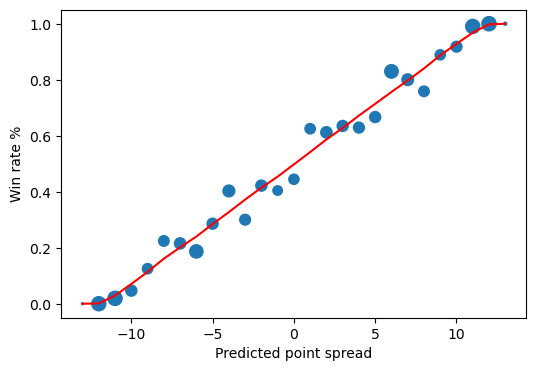

In [144]:
# win margin model predictions and win probability spline fit on the same plot
df = pd.DataFrame({'pred': np.round(oof_preds,0), 
                   'label': np.array(oof_targets)>0, 
                   'spline_fit': spline_fit})
df = df.groupby('pred')[['label', 'spline_fit']].agg(['mean', 'count']).reset_index()

fig, ax1 = plt.subplots(figsize = (6,4))
ax1.scatter(df['pred'], df['label']['mean'], df['label']['count'])
ax1.plot(df['pred'], df['spline_fit']['mean'], 'r')
ax1.set_xlabel('Predicted point spread')
ax1.set_ylabel('Win rate %')
plt.show()

In [145]:
# construct dataframe for submission
X = sample_submission.copy()
X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))
X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))
X['men_women'] = X['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1)
X = pd.merge(X, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T1_std, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, season_statistics_T2_std, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, fivethirtyeight_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, fivethirtyeight_T2, on = ['Season', 'T2_TeamID'], how = 'left')

NameError: name 'sample_submission' is not defined

In [ ]:
# inference for every model, take average as final prediction
preds = []
for oof_season in set(tourney_data.Season):
    dtest = xgb.DMatrix(X[features].values)
    margin_preds = models[oof_season].predict(dtest)
    probs = np.clip(spline_model(np.clip(margin_preds, -t, t)), 0, 1)
    preds.append(probs)
X['Pred'] = np.array(preds).mean(axis=0)    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# sanity check to check for win probability distribution
m = X.loc[(~pd.isnull(X.T1_seed)) & (~pd.isnull(X.T2_seed))]
plt.figure(figsize=(6, 3))
plt.xlim(0, 1)
sns.histplot(m['Pred'], bins=42)

In [ ]:
pd.pivot_table(data = df, index='T1_seed', columns='T2_seed', values='pred', aggfunc='mean').style.bar(color='#5fba7d', vmin=0, vmax=1)

KeyError: 'T1_seed'